In [21]:
"""Import library"""
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50V2 as ResNet
from tensorflow.keras.callbacks import EarlyStopping,  ReduceLROnPlateau
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 28)

import random
import os

!pip install imutils
import imutils
from imutils.contours import sort_contours

In [22]:
def extractImages(datadir):
    # Get the data
    imagesData = []
    imagesLabel = []
    for folder in os.listdir(datadir):
        path = os.path.join(datadir, folder)
        for images in os.listdir(path):
            img = cv2.imread(os.path.join(path, images), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (32, 32))
            imagesData.append(img)
            imagesLabel.append(folder)

    # Shuffle data
    combined = list(zip(imagesData, imagesLabel))
    random.shuffle(combined)
    imagesData, imagesLabel = zip(*combined)

    return (imagesData, imagesLabel)

In [23]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/data.zip
!unzip -qo data.zip

--2024-09-05 21:29:30--  https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/data.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.156.207, 52.219.64.0, 52.219.160.103, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.156.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28437489 (27M) [application/x-zip-compressed]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]  27.12M  7.79MB/s    in 3.5s    

2024-09-05 21:29:34 (7.79 MB/s) - ‘data.zip.1’ saved [28437489/28437489]



In [4]:
# Import train data
imagesData = []
imagesLabel = []
train_data_dir = 'data/dataset'

imagesData, imagesLabel = extractImages(train_data_dir)

print("number of image: ",len(imagesData))
print("shape of image:  ",imagesData[1].shape)
print("labels:          ",list(set(imagesLabel)))

number of image:  7600
shape of image:   (32, 32)
labels:           ['9', '1', '4', 'add', '6', '5', 'sub', '8', 'mul', '0', 'div', '3', '7', '2']


In [5]:
imagesTrainData, imagesTestData, imagesTrainLabel, imagesTestLabel = train_test_split(
                                                                                    imagesData,imagesLabel,
                                                                                    shuffle=True,
                                                                                    test_size=0.2,
                                                                                    random_state=42,
                                                                                    stratify= imagesLabel )

In [6]:
# Show Image
def showImage (images,label,part):
    figure = plt.figure(figsize=((len(part)/10 + 1)*10, (len(part)/10 + 1)*2))
    j = 0
    for i in part:
        lbl = label[i]
        img = images[i]
        img = cv2.resize(img, (256, 256))
        figure.add_subplot(int(len(part)/10)+1, 10, j+1)
        plt.imshow(img,cmap='gray')
        plt.axis('off')
        plt.title(lbl)
        j += 1

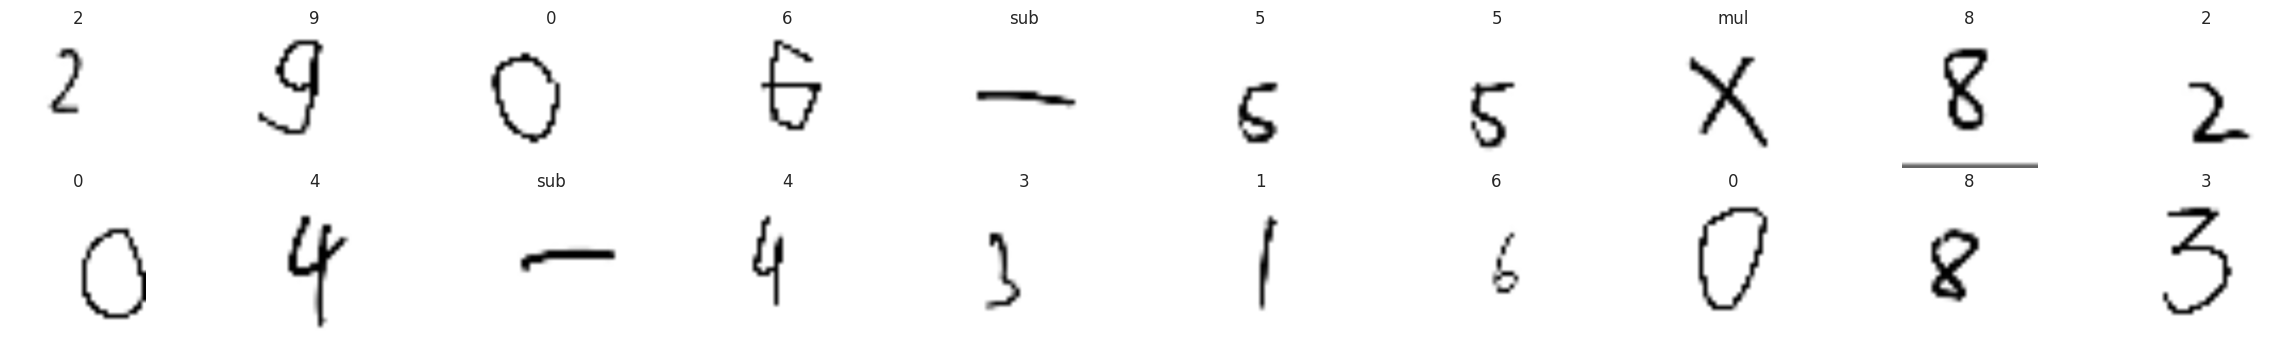

In [7]:
showImage(imagesTrainData,imagesTrainLabel, range(20))


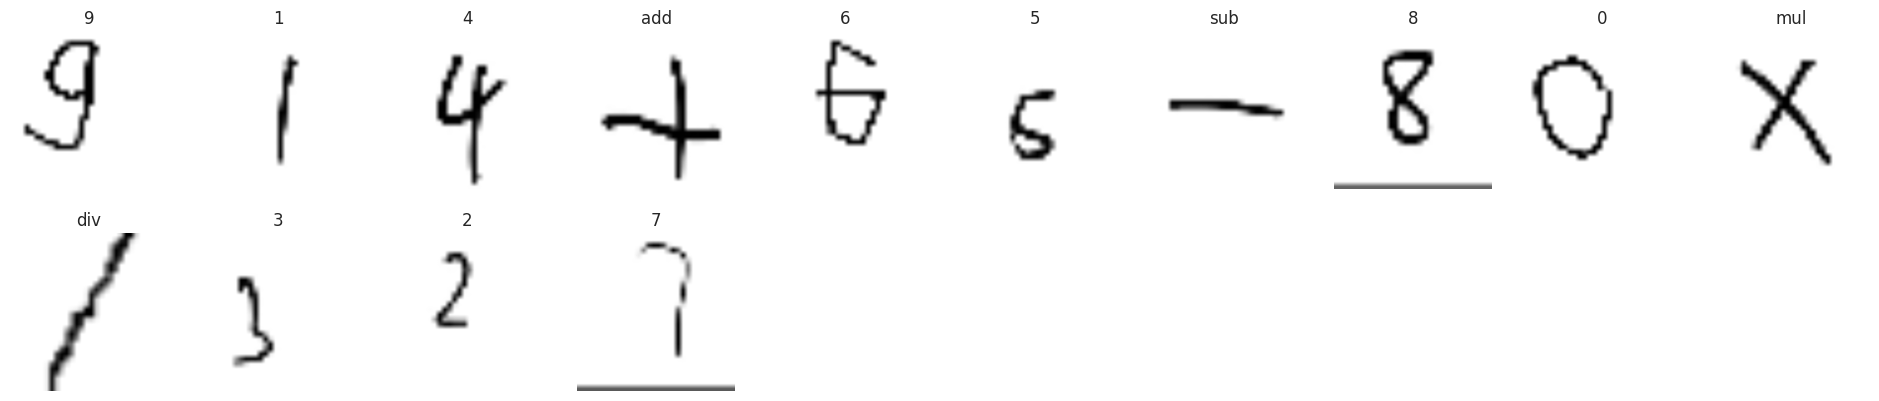

In [8]:
unique_idx = [imagesTrainLabel.index(i) for i in list(set(imagesTrainLabel))]
showImage(imagesTrainData,imagesTrainLabel, unique_idx )

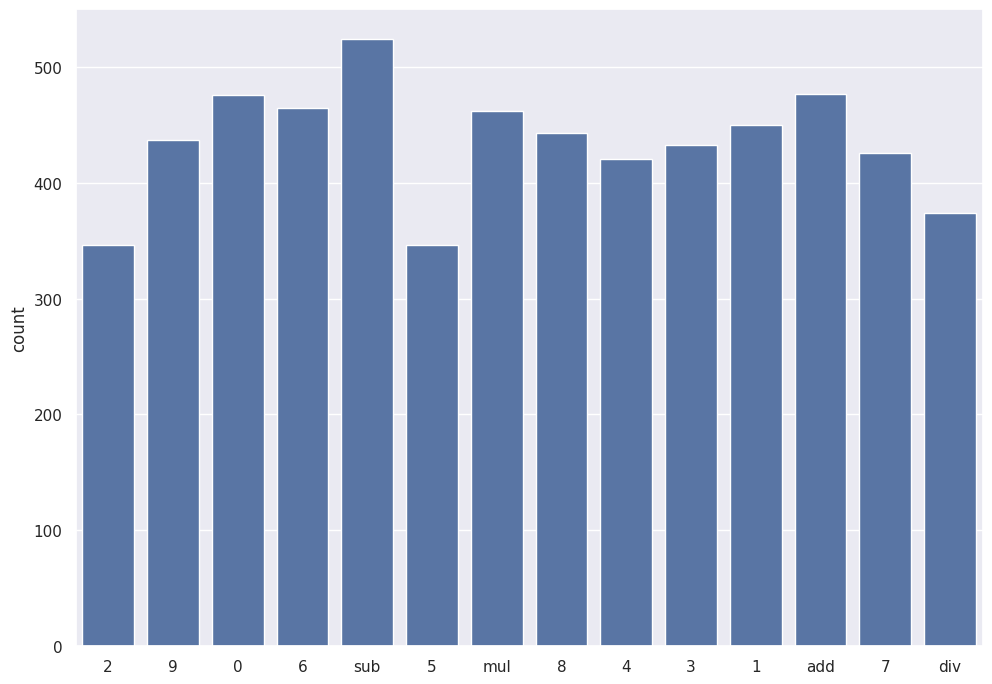

In [9]:
sns.countplot(x= list(imagesTrainLabel));

In [10]:
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(imagesTrainLabel)
Y_test = label_encoder.transform(imagesTestLabel)

In [11]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [12]:
X_train = np.array(imagesTrainData)
X_test = np.array(imagesTestData)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6080, 32, 32, 1)
(1520, 32, 32, 1)
(6080, 14)
(1520, 14)


In [13]:
X_train[0].shape

(32, 32, 1)

In [14]:
def facial_recognition_detect_mood(input_shape=(32, 32, 1)):


    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(14, activation='softmax'))

    model.compile(optimizer=Adam(lr=0.0001,),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [15]:
def facial_recognition_detect_mood(input_shape=(32, 32, 1)):


    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(14, activation='softmax'))

    # Use learning_rate instead of lr
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [16]:
model = facial_recognition_detect_mood()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       8,389,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │          14,350 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,441,934 (32.20 MB)

 Trainable params: 8,441,614 (32.20 MB)

 Non-trainable params: 320 (1.25 KB)

In [17]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('HandwrittenMathEquationModel.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='min')

earlyStopping = EarlyStopping(monitor='val_accuracy',
                              mode='auto',
                              verbose=1,
                              patience=10,
                              restore_best_weights=True)

reduceLr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [checkpoint,earlyStopping,reduceLr, LearningRateScheduler(step_decay)]

In [18]:
!pip install tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming you want basic image augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

hist = model.fit(aug.flow(X_train, Y_train, batch_size=64),
                 batch_size=64,
                 epochs=90,
                 validation_data=(X_test, Y_test),
                 callbacks=callbacks)

Epoch 1/90


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2431 - loss: 6.8828
Epoch 1: val_accuracy improved from inf to 0.07566, saving model to HandwrittenMathEquationModel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.2438 - loss: 6.8531 - val_accuracy: 0.0757 - val_loss: 5.1993 - learning_rate: 0.0010
Epoch 2/90
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4467 - loss: 2.1943
Epoch 2: val_accuracy did not improve from 0.07566
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4469 - loss: 2.1934 - val_accuracy: 0.1599 - val_loss: 10.6411 - learning_rate: 0.0010
Epoch 3/90
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5031 - loss: 1.8377
Epoch 3: val_accuracy did not improve from 0.07566
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5033 - loss: 1.8366 - val_accuracy: 0.1776 - val_loss: 14.5458 - learning_rate: 0.0010
Epoch 4/90
90/95 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5614 - loss: 1.5851
Epoch 4: val_accuracy did not improve from 

In [19]:
model.save('HandwrittenMathEquationModel.h5')

In [20]:
import os
from google.colab import files
print( os.getcwd() )
files.download( "HandwrittenMathEquationModel.h5" )

/content


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>